# DENSITY PEAKS ALGORYTHM

In [1]:
import numpy as np
from typing import NamedTuple, Tuple
from matplotlib import pyplot as plt
from numba import njit,jit, config #High performance JIT compiler and parallelization libraries

In [2]:
X_data = np.loadtxt("Aggregation.txt")
X_data = X_data[:,[0,1]]

In [3]:
def local_density(X: np.ndarray, kind, dc):
    """
    Compute all points's local density.
    Args: X: data
    Kind: True if gaussian init or False for exact initialization
    dc= free parameter for distance threshold
    returns: local density vector
             distance matrix
    """
    n,d = X.shape
    rho_vector = np.zeros(n)
    distances = np.zeros((n,n))
    
    rho_func = lambda dij, dc: np.exp(- (dij / dc) ** 2)
    cutoff_func = lambda dij, dc: 1 if dij < dc else 0
    func = rho_func if kind else cutoff_func
        
    for i in range(n):
        for j in range(i + 1, n):
            distance = np.sqrt(((X[i,:] - X[j,:])**2).sum(axis=0)) 
            distances[i, j] = distance
            distances[j, i] = distance
        
    for i in range(n):
        for j in range(i+1,n):
            temp = func(distances[i, j], dc)
            rho_vector[i] += temp
            rho_vector[j] += temp
            
    return rho_vector, distances

In [4]:
def delta_and_distance(X: np.ndarray, distances, rho):
    """
    Compute all points's min with respect to the higher local density point(delta distance).
    X: data
    distaneces: Matrix containing the distances between points
    rho : vector contaning local density
    :return: delta distance vector, nearest neighbor vector
    """
    
    n,_ = X.shape
    sorted_rho = np.argsort(-rho)
    delta = np.zeros(n)
    near_neigh = np.zeros(n)
    
    # For the point which has the higher density 
    delta[sorted_rho[0]] = distances[sorted_rho[0],:].max()
    max_dat = distances[sorted_rho[0],[i for i, x in enumerate(distances[sorted_rho[0],:]) if x.any()]]
    near_neigh[sorted_rho[0]] = sorted_rho[0]

    #For the rest
    for i in range(1,n):
        min_delta= distances[sorted_rho[i],sorted_rho[0]]
        near_neigh[sorted_rho[i]] = sorted_rho[0]
        for j in range(2,i+1):
            if i == j:
                continue
            _delta= distances[sorted_rho[i],sorted_rho[j]]
            if _delta<min_delta:
                min_delta = _delta
                near_neigh[sorted_rho[i]] = sorted_rho[j]
        
        delta[sorted_rho[i]]= min_delta
            
    return delta, near_neigh

In [13]:
def decision_plot_cluster_assignment(X: np.ndarray, kind, dc, gamma):
    """
    Plots the decision plot which has the points that will be the cluster centers
    ARgs: X: data
    Kind: True if gaussian init or False for exact initialization
    dc= free parameter for distance threshold
    gamma: free parameter for cluster selection
    return: centers of the cluster
            vector of cluster assignation
            labels for clusters
    """
    
    rho , distances = local_density(X,kind,dc)
    delta, near_n= delta_and_distance(X,distances,rho)
    
    n, d = X_data.shape
    plt.scatter(rho,delta)
    plt.plot(rho,gamma/rho)
    plt.plot(rho,[dc]*n)

    centers = np.zeros((n,d))
    cluster = np.zeros(n)
    labels = np.zeros(n)
    
    for idx, delta_val in enumerate(delta):
    
        if delta_val >= 2.5:
            cluster[idx] = idx
            labels[idx] = idx
            centers[idx] = X_data[idx]
        else:
            cluster[idx] = -1
        
    centers = centers[[i for i, x in enumerate(centers) if x.any()]]
    labels = labels[[i for i, x in enumerate(labels) if x.any()]]
    
    # assignation
    sorted_rho = np.argsort(-rho)
    for i in range(sorted_rho.shape[0]):
        if cluster[sorted_rho[i]] == -1:
            cluster[sorted_rho[i]] = cluster[int(near_n[sorted_rho[i]])]
            
    return centers, cluster, labels

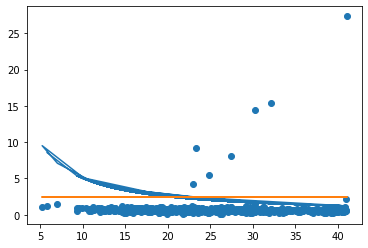

In [14]:
centers , cluster, labels= decision_plot_cluster_assignment(X_data, True, 2.5, 50)

In [15]:
def plot_DP( cluster , title=""):
    """
    Plot cluster.
    :param title: title to plot
           cluster : vector contaning the cluster assignation
    :return: None
    """

    title_ = "Cluster assignation using Density Peaks" if title == "" else title
    plt.scatter(X_data[:,0], X_data[:,1], c=cluster)
    plt.title(title_)

    plt.show()

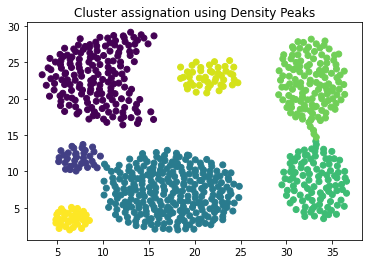

In [16]:
plot_DP(cluster)

In [17]:
def F_ratio_test(X, cluster, labels, centers):
    """
    F ratio test for comparing clustering
    :param X: data
           cluster : vector contaning the cluster assignation
           labels: vector containing cluster labeling
           centers: vector containig the cluster centers
    :return: F VALUE
    """
    n , _ = X.shape
    k = labels.shape[0]
    X_mean = np.mean(X, axis=0)
    
    SSW = 0
    SSB = 0
    
    for i in range(k):
        for j in range(n):
            if int(cluster[j]) == int(labels[i]):
                dist = ((X[j,:] - centers[i,:])**2).sum()
                SSW = SSW + dist
    
    for j in range(k):
        n_j = np.count_nonzero(cluster == labels[j])
        inter_distance = ((centers[j] - X_mean)**2).sum()
        SSB = SSB + n_j*inter_distance
    
    F = k*SSW/SSB
    return F

In [18]:
F_ratio_test(X_data,cluster,labels,centers)

0.8639409727670929